In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import json
import os
import numpy as np
import matplotlib.pyplot as plt

In [34]:
class HandLandmarkDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.file_list = []
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                self.file_list.append((os.path.join(class_dir, file_name), class_idx))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, class_idx = self.file_list[idx]
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Extract x, y, z coordinates from each landmark
        landmarks = data[0]  # Assuming the first (and only) item in the list is the landmarks
        flattened_landmarks = []
        for landmark in landmarks:
            flattened_landmarks.extend([landmark['x'], landmark['y'], landmark['z']])
        
        # Convert to tensor
        landmarks_tensor = torch.tensor(flattened_landmarks, dtype=torch.float32)
        
        return landmarks_tensor, class_idx
    
    def get_class_names(self):
        return self.classes

In [58]:
class HandLandmarkModel(nn.Module):
    def __init__(self, input_size=63, num_classes=6): # Change num classes depends on your class
        super(HandLandmarkModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Check if the input is a single sample and unsqueeze if necessary
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        x = self.fc1(x)
        x = self.bn1(x) if x.size(0) > 1 else x  # Apply BatchNorm only for batch size > 1
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x) if x.size(0) > 1 else x
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x) if x.size(0) > 1 else x
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.bn4(x) if x.size(0) > 1 else x
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)


In [59]:
# Create a sample input tensor
sample_input = torch.randn(63)  # Single sample
batch_input = torch.randn(32, 63)  # Batch of 32 samples

# Initialize the model
model = HandLandmarkModel()

# Forward pass with single sample
output_single = model(sample_input)

# Forward pass with batch
output_batch = model(batch_input)

print(f"Single input shape: {sample_input.shape}")
print(f"Single output shape: {output_single.shape}")
print(f"Batch input shape: {batch_input.shape}")
print(f"Batch output shape: {output_batch.shape}")
print(f"Model architecture:\n{model}")

Single input shape: torch.Size([63])
Single output shape: torch.Size([1, 6])
Batch input shape: torch.Size([32, 63])
Batch output shape: torch.Size([32, 6])
Model architecture:
HandLandmarkModel(
  (fc1): Linear(in_features=63, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=6, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [60]:
def infer(model, input_data, device):
    model.to(device)
    input_tensor = torch.FloatTensor(input_data).unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    return predicted_class, probabilities.squeeze().cpu().numpy()

def load_model(model_path, input_size, num_classes):
    model = HandLandmarkModel(input_size, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

In [61]:
from modules.model_trainer import ModelTrainer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from modules.model_performance import ModelPerformanceVisualizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32
learning_rate = 0.0001
NUM_EPOCHS = 1000
weight_decay = 1e-5  # L2 regularization

dataset = HandLandmarkDataset("landmark_ds")
class_names = dataset.get_class_names()
input_size = dataset[0][0].shape[0]  # Get the size of a single input
num_classes = len(dataset.classes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [62]:
class_names = dataset.get_class_names()
print("Class names:")
for idx, name in enumerate(class_names):
    print(f"  {idx}: {name}")

Class names:
  0: 0
  1: 1
  2: 2
  3: 3
  4: 4
  5: 5


ModelTrainer initialized with device: cuda
CUDA device: NVIDIA GeForce GTX 1070
CUDA available: True
Current CUDA device: 0
Training on device: cuda
Model is on device: cpu
Moving model to cuda
After moving, model is on device: cuda:0


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7107 | train_acc: 0.2917 | test_loss: 1.6297 | test_acc: 0.4740 | lr: 0.000100
Epoch: 2 | train_loss: 1.4496 | train_acc: 0.5153 | test_loss: 1.1655 | test_acc: 0.9505 | lr: 0.000100
Epoch: 3 | train_loss: 1.2407 | train_acc: 0.6708 | test_loss: 0.9501 | test_acc: 0.9688 | lr: 0.000100
Epoch: 4 | train_loss: 1.1017 | train_acc: 0.7486 | test_loss: 0.8135 | test_acc: 0.9766 | lr: 0.000100
Epoch: 5 | train_loss: 0.9408 | train_acc: 0.8424 | test_loss: 0.6826 | test_acc: 0.9922 | lr: 0.000100
Epoch: 6 | train_loss: 0.8254 | train_acc: 0.8854 | test_loss: 0.6001 | test_acc: 0.9974 | lr: 0.000100
Epoch: 7 | train_loss: 0.7330 | train_acc: 0.9139 | test_loss: 0.5042 | test_acc: 1.0000 | lr: 0.000100
Epoch: 8 | train_loss: 0.6642 | train_acc: 0.9243 | test_loss: 0.4247 | test_acc: 1.0000 | lr: 0.000100
Epoch: 9 | train_loss: 0.5878 | train_acc: 0.9382 | test_loss: 0.3490 | test_acc: 1.0000 | lr: 0.000100
Epoch: 10 | train_loss: 0.5243 | train_acc: 0.9569 | test_loss: 

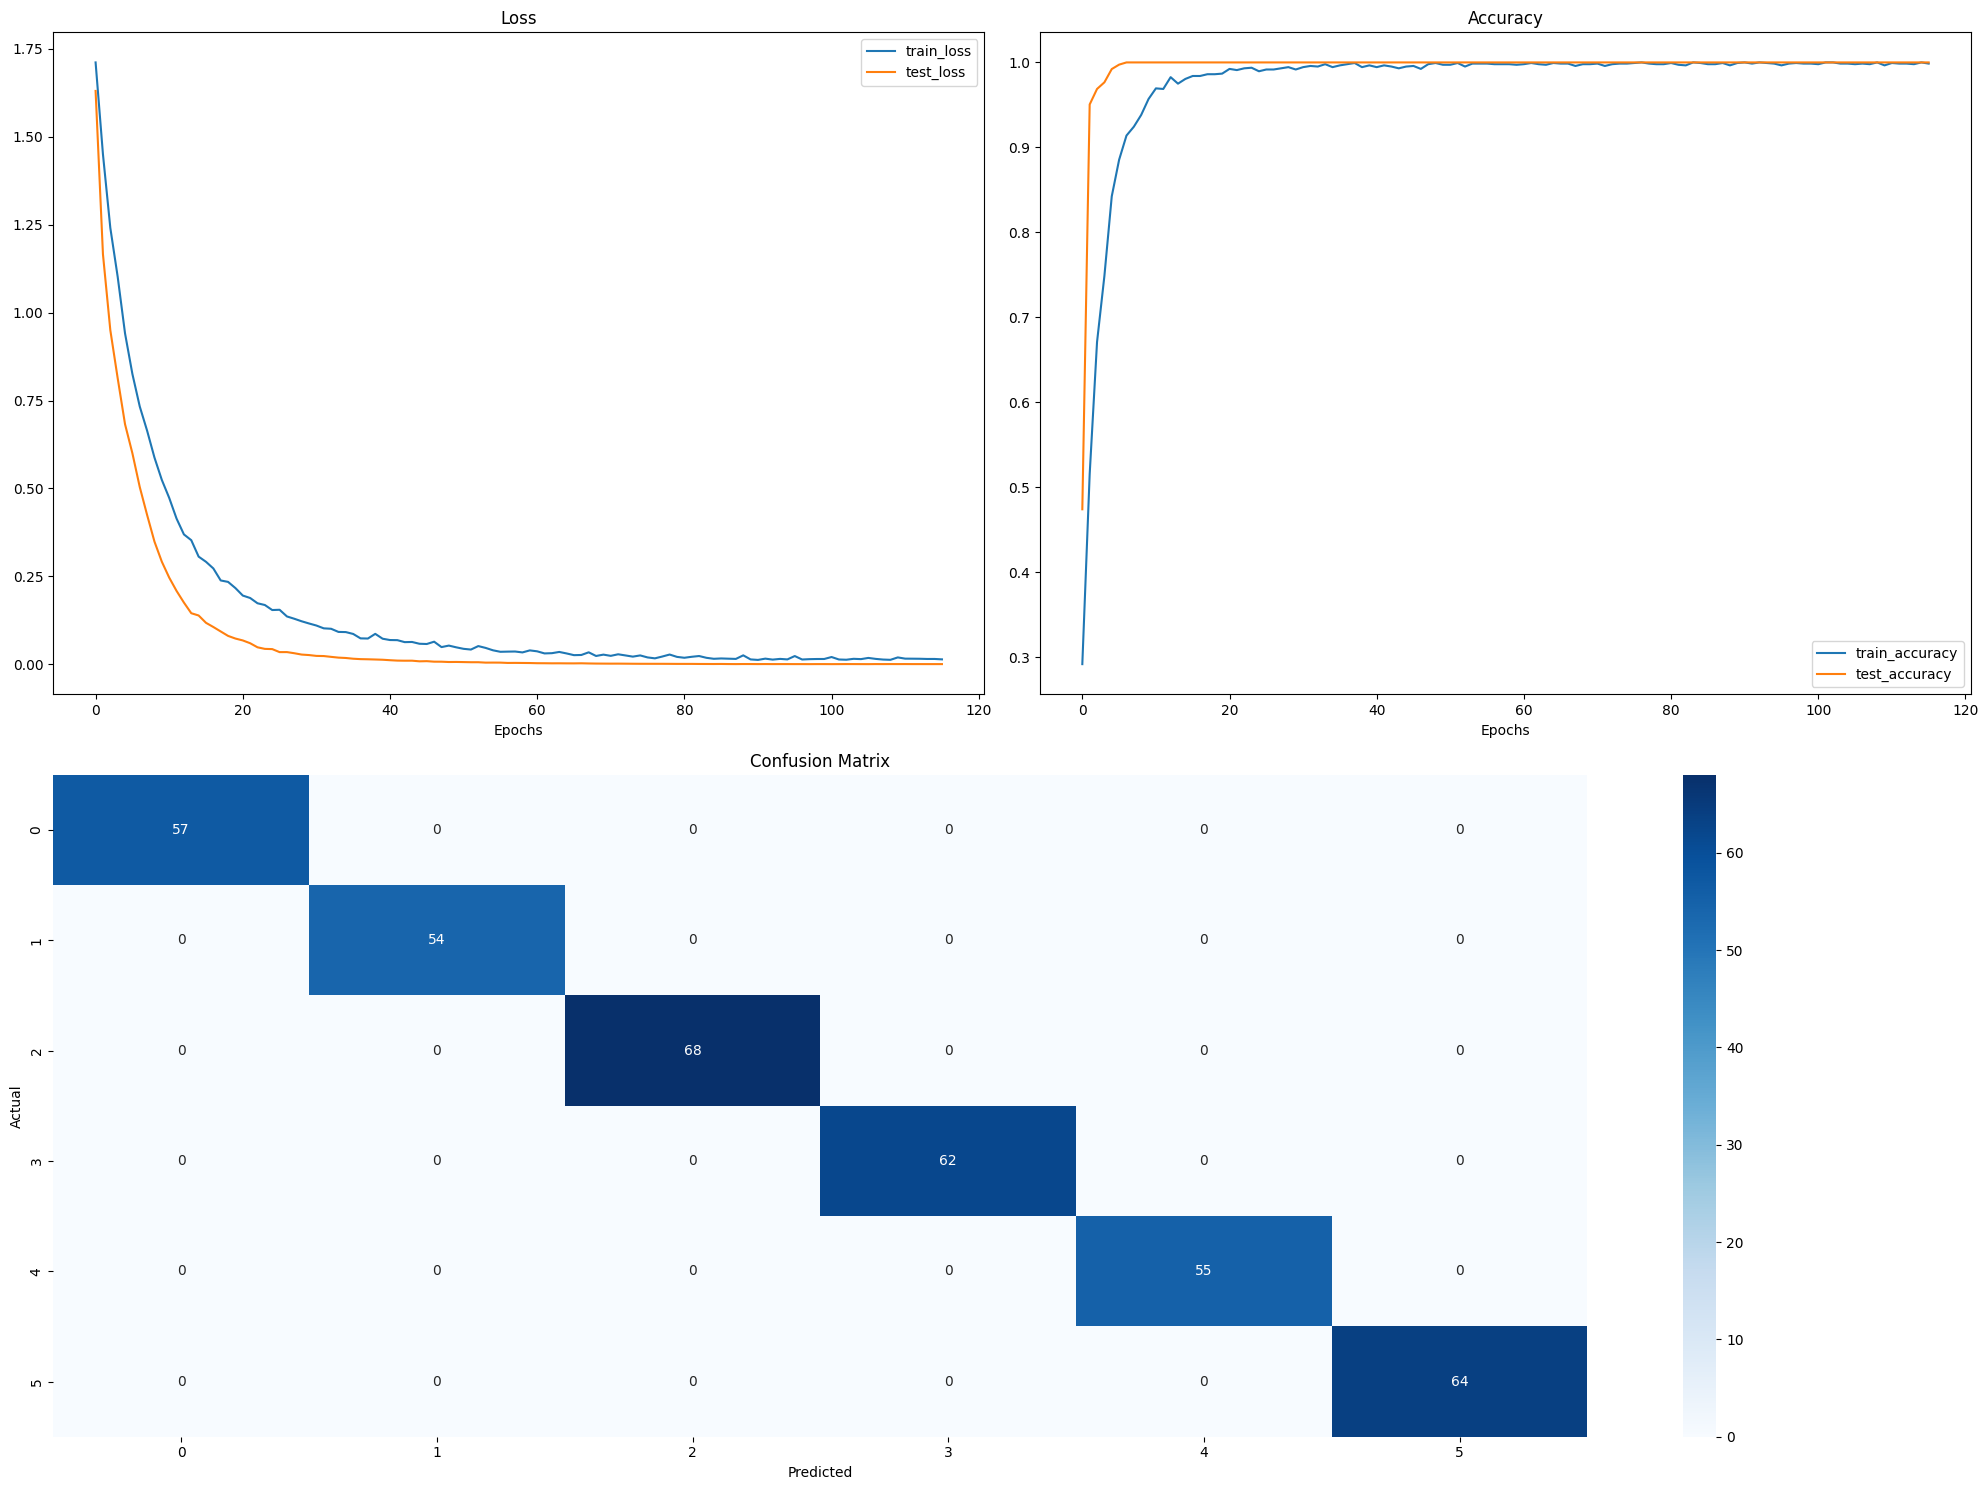

Model saved as landmark_5_classes.pth


In [63]:
model = HandLandmarkModel(input_size, num_classes)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)


trainer = ModelTrainer()
TRAINED_MODEL, RESULTS = trainer.train(
    model=model,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=NUM_EPOCHS,
    scheduler=scheduler,
    patience=None 
)


# Plot the results
visualizer = ModelPerformanceVisualizer(RESULTS)
y_true, y_pred = visualizer.get_preds(model=TRAINED_MODEL, dataloader=test_dataloader, device=device)
visualizer.plot_all(y_true=y_true, y_pred=y_pred, classes=class_names, save_path="model_performance/plot.jpg")

model_name = "landmark_5_classes.pth"

# Save the model
torch.save(model.state_dict(), model_name)
print(f"Model saved as {model_name}")

In [64]:
from modules.model_saver import ModelSaver

saver = ModelSaver(target_dir="models")
loaded_model = saver.load_model(model=model, model_name=model_name)

[INFO] Loading model from: models\landmark_5_classes.pth


In [65]:
from modules.model_eval import ModelEvaluator

evaluator = ModelEvaluator(loaded_model)
results = evaluator.evaluate_and_report(test_dataloader, class_names)

print(f"Accuracy: {results['accuracy']:.4f}")
print("Classification Report:")
print(results['classification_report'])

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        54
           2       1.00      1.00      1.00        68
           3       1.00      1.00      1.00        62
           4       1.00      1.00      1.00        55
           5       1.00      1.00      1.00        64

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



In [66]:
def convert_to_torchscript(model, example_input, filename):
    model.eval()  # Set the model to evaluation mode
    
    # Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing
    traced_script_module = torch.jit.trace(model, example_input)
    
    # Save the TorchScript model
    traced_script_module.save(f"{filename}.ptl")
    print(f"TorchScript model saved to {filename}")

In [67]:
model = HandLandmarkModel()

# Create an example input
example_input = torch.randn(1, 63)  # Batch size of 1, 63 features

# Convert and save the model
convert_to_torchscript(model, example_input, model_name)

TorchScript model saved to landmark_5_classes.pth


C:\Users\cloud\AppData\Local\Temp\ipykernel_15392\2091413184.py:21: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  x = self.bn1(x) if x.size(0) > 1 else x  # Apply BatchNorm only for batch size > 1
C:\Users\cloud\AppData\Local\Temp\ipykernel_15392\2091413184.py:26: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  x = self.bn2(x) if x.size(0) > 1 else x
C:\Users\cloud\AppData\Local\Temp\ipykernel_15392\2091413184.py:31: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python value

In [68]:
# Test loading and inference
loaded_model = torch.jit.load("landmark_5_classes.ptl")
test_input = torch.randn(1, 63)
output = loaded_model(test_input)
print(f"Test output shape: {output.shape}")

Test output shape: torch.Size([1, 6])


In [69]:
import cv2
import mediapipe as mp
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
from PIL import Image

# MediaPipe setup for hand landmark detection
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Load the TorchScript model
model = torch.jit.load("landmark_5_classes.ptl")
model.eval()

RecursiveScriptModule(
  original_name=HandLandmarkModel
  (fc1): RecursiveScriptModule(original_name=Linear)
  (bn1): RecursiveScriptModule(original_name=BatchNorm1d)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (bn2): RecursiveScriptModule(original_name=BatchNorm1d)
  (fc3): RecursiveScriptModule(original_name=Linear)
  (bn3): RecursiveScriptModule(original_name=BatchNorm1d)
  (fc4): RecursiveScriptModule(original_name=Linear)
  (bn4): RecursiveScriptModule(original_name=BatchNorm1d)
  (fc5): RecursiveScriptModule(original_name=Linear)
  (dropout): RecursiveScriptModule(original_name=Dropout)
)

In [20]:
with open('class_names.json', 'r') as f:
    class_names = json.load(f)

In [80]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    image_rgb = np.array(image.convert('RGB'))
    return image_rgb

def detect_hand_landmarks(image_rgb):
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3) as hands:
        results = hands.process(image_rgb)
        return results.multi_hand_landmarks

def process_landmarks(landmarks):
    if landmarks:
        landmark_list = []
        for landmark in landmarks[0].landmark:
            landmark_list.extend([landmark.x, landmark.y, landmark.z])
        return torch.tensor(landmark_list, dtype=torch.float32).unsqueeze(0)
    return None

def classify_landmarks(landmark_tensor):
    with torch.no_grad():
        output = model(landmark_tensor)
        probabilities = torch.exp(output)
        top_prob, top_class = torch.topk(probabilities, 1)
        return top_class.item(), top_prob.item()

def visualize_results(image_rgb, landmarks, class_id, probability):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_rgb)
    
    if landmarks:
        for landmark in landmarks[0].landmark:
            x, y = int(landmark.x * image_rgb.shape[1]), int(landmark.y * image_rgb.shape[0])
            ax.plot(x, y, 'ro', markersize=5)
    
    class_name = class_names[int(class_id)]
    ax.text(10, 30, f"Class: {class_name}", fontsize=12, color='green', backgroundcolor='black')
    ax.text(10, 60, f"Prob: {probability:.2f}", fontsize=12, color='green', backgroundcolor='black')
    print(f"Class: {class_name}")
    print(f"Prob: {probability:.2f}")
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    plt.show()

def classify_hand_image(image_path):
    image_rgb = preprocess_image(image_path)
    landmarks = detect_hand_landmarks(image_rgb)
    
    if landmarks:
        landmark_tensor = process_landmarks(landmarks)
        class_id, probability = classify_landmarks(landmark_tensor)
        visualize_results(image_rgb, landmarks, class_id, probability)
    else:
        print("No hand detected in the image.")
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

Class: 2
Prob: 0.18


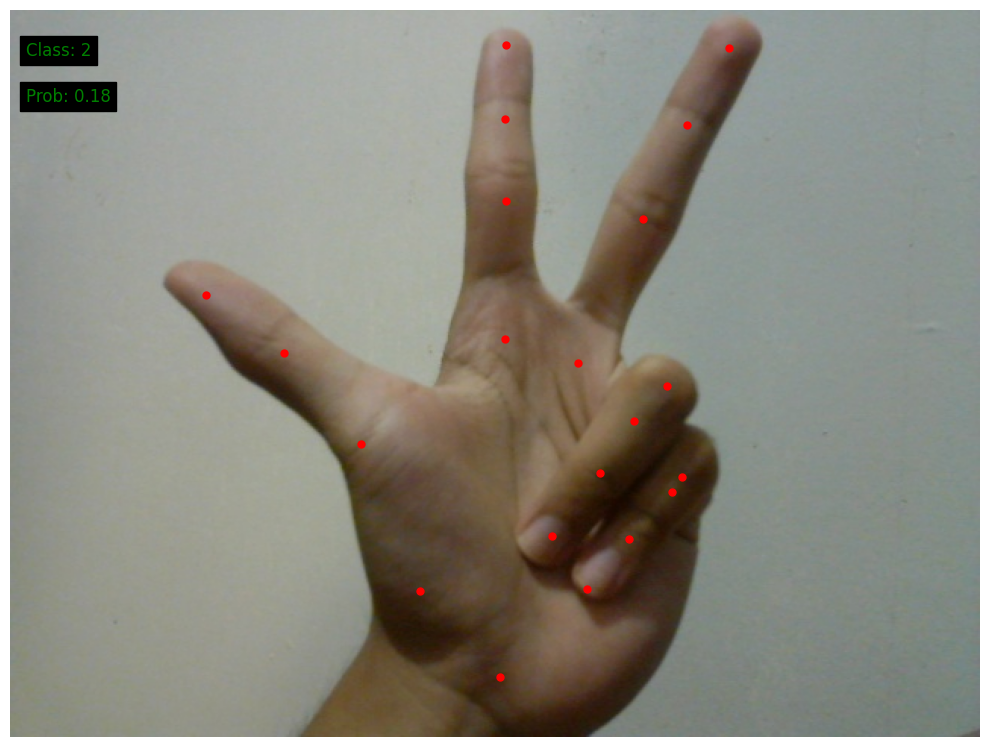

In [84]:
image_path = "xandra/3/3_LEFT_C_1.jpg"
classify_hand_image(image_path)